# Projet 4 - Analysez les ventes de votre entreprise

Nous allons étudier les ventes de livres en ligne de la société.

Pour se faire nous allons tout d'abord nettoyer les données provenant de la base de donnée, ensuite les analyser pour en tirer les informations pertinentes, et enfin vérifier les corrélations suivantes :

* Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
* Y a-t-il une corrélation entre l'âge des clients et :
    * Le montant total des achats ;
    * La fréquence d’achat (ie. nombre d'achats par mois par exemple) ;
    * La taille du panier moyen (en nombre d’articles) ;
    * Les catégories de produits achetés.

## Table des matières

1. __Importation des données__


2. __Vérification de données manquantes__

    1. Fichier customers
    2. Fichier products
    3. Fichier transactions
    
    
3. __Nettoyage des fichiers__

    1. Nettoyage des données de test
    2. Mise au format Datetime de la colonne date


4. __Préparation du dataFrame de travail__

    1. Assemblage des 3 fichiers en 1 seul
    2. Création de nouvelles colonnes
    3. Test Unitaire
    

5. __Visualisations des données__
    
    1. Colonne birth, age, cat_age et sexe
    2. Colonne price, cat_price et categ
    3. Colonne date, weekday, daytime, month, week, year
    4. Colonne session_amount, session_nb_produit et session_categ
    5. Conclusion
    

6. __Analyses des données__
    
    1. Produits les plus vendus



## 1. Importation des données

Dans un premier temps, nous allons importer les données

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(color_codes = True)

In [2]:
customers = pd.read_csv('./Dataset/customers.csv')
products = pd.read_csv('./Dataset/products.csv')
transactions = pd.read_csv('./Dataset/transactions.csv', parse_dates=[1])

Nous allons, maintenant, regarder les dataFrames pour remarquer les valeurs manquantes

## 2. Vérification de données manquantes

### A. Fichier customers

In [3]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [4]:
customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [5]:
customers['birth'].value_counts()

2004    440
1979    215
1988    207
1986    203
1978    199
       ... 
1935      8
1932      6
1931      4
1930      4
1929      3
Name: birth, Length: 76, dtype: int64

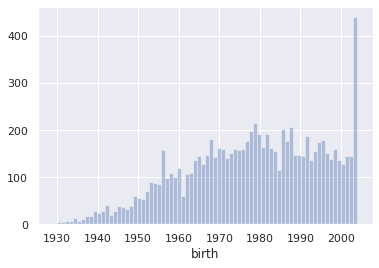

In [6]:
sns.distplot(customers['birth'], kde=False, bins=76)

Nous avons, ici, pour les années de naissances, environ 5% des clients qui sont nés en 2004. Est-ce un erreur ou une particularité à relever du site, qui cible les adolescents. Est-ce que dans l'inscription en ligne, cette année comprends les clients nés en 2004 et avant ?

Le reste du dataFrame ne présente pas de valeurs manquantes ou erronées

### B. Fichier products

In [7]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [8]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [9]:
products['price'].value_counts()

4.99     85
6.99     84
3.99     80
5.99     78
8.99     74
         ..
4.13      1
2.84      1
13.13     1
18.77     1
9.00      1
Name: price, Length: 1455, dtype: int64

In [10]:
products['categ'].value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

In [11]:
products.nsmallest(10, 'price')

,id_prod,price,categ
731,T_0,-1.00,0
2272,0_528,0.62,0
2355,0_202,0.62,0
370,0_120,0.66,0
1211,0_1844,0.77,0
1530,0_1620,0.80,0
2302,0_1364,0.81,0
2425,0_612,0.88,0
2772,0_902,0.92,0
686,0_2138,0.93,0


In [12]:
products.nlargest(10, 'price')

,id_prod,price,categ
947,2_2,300.00,2
724,2_76,254.44,2
394,2_158,247.22,2
1436,2_167,236.99,2
2779,2_30,233.54,2
1960,2_125,231.99,2
2487,2_166,230.04,2
786,2_40,228.11,2
10,2_228,225.17,2
1896,2_4,222.97,2


Nous remarquons qu'un produit à une valeur de -1, est-ce qu'il correspond à une valeur test, comme le 'T' dans son identifiant le laisse présager ?

Le reste du dataFrame ne présente pas de valeurs manquantes ou erronées.

### C. Fichier transactions

In [13]:
transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [14]:
transactions.describe()

,id_prod,date,session_id,client_id
count,337016,337016,337016,337016
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,1081,13,200,12855


Nous constatons que certains articles n'ont pas été vendu, nous avons 3266 produits uniques de vendu sur un total de 3287 produits référencés. De plus, nous avons certains clients qui n'ont éffectués aucun achat, nous avons, dans le dataframe transaction 8502 clients uniques alors qu'il y a 8623 clients d'enregistrés.

Nous avons dans la colonne date une valeur test : test_2021-03-01 02:30:02.237413

## 3. Nettoyage des fichiers

### A. Nettoyage des données de test

Tout d'abord, nous allons enlever les données de test rentrées dans les dataFrames.

In [15]:
transactions[transactions['date'].str.contains('test')]

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1
...,...,...,...,...
332594,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0
332705,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1
332730,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1
333442,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1


Nous remarquons que les tests ont été fait avec d'autres éléments prédéfinis. Nous allons rechercher ces éléments pour les enlever de nos dataFrames pour éviter de fausser notre analyse.

In [16]:
transactions.loc[transactions['date'].str.contains('test')].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


Nous remarquons que nous avons un produit unique (T_0), une session unique (s_0), et deux clients uniques (ct_0 et ct_1). Nous allons enlever ces éléments après vérification

In [17]:
transactions.loc[transactions['id_prod'] == 'T_0'].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


Le client T_0 n'a été utilisé que pour les tests

In [18]:
transactions.loc[transactions['session_id'] == 's_0'].describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


De même, la session s_0 n'a été utilisé que pour les tests

In [19]:
transactions.loc[transactions['client_id'] == 'ct_0'].describe()

,id_prod,date,session_id,client_id
count,106,106,106,106
unique,1,37,1,1
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,106,9,106,106


In [20]:
transactions.loc[transactions['client_id'] == 'ct_1'].describe()

,id_prod,date,session_id,client_id
count,94,94,94,94
unique,1,37,1,1
top,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1
freq,94,5,94,94


Pour finir, les clients ct_0 et ct_1 ont été également utilisé que pour les tests.

Nous allons supprimer les 200 lignes contenant des dates de test

In [21]:
transactions = transactions[~transactions['date'].str.contains('test')]

Nous allons effacer le produit test T_0, d'une valeur négative, de la dataFrame products

In [22]:
products = products[~(products['id_prod'] == 'T_0')]

Nous allons effacer les clients ct_0 et ct_1 de la dataFrame customers

In [23]:
customers[customers['client_id'].str.contains('ct_')].describe()

,birth
count,2.0
mean,2001.0
std,0.0
min,2001.0
25%,2001.0
50%,2001.0
75%,2001.0
max,2001.0


Nous n'avons que deux clients possèdant le préfixe 'ct', les clients tests, que nous allons enlever du dataFrame

In [24]:
customers = customers[~customers['client_id'].str.contains('ct_')]

Nous allons convertir la colonne date du dataFrame transactions en valeur de type datetime64

### B. Mise au format Datetime de la colonne *date*

In [25]:
transactions['date'] = pd.to_datetime(transactions['date'])

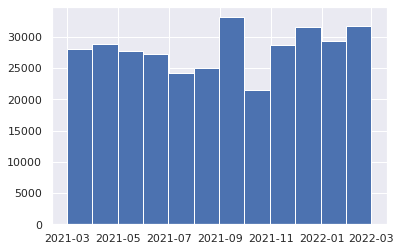

In [26]:
transactions['date'].hist(bins = 12)

Nous constatons que les dates s'étalent sur 1 an de Mars 2021 à Mars 2022.

## 4. Préparation du dataFrame de travail

### A. Assemblage des 3 fichiers en 1 seul

Nous allons merger les 3 dataFrames en 1 seul pour faciliter l'analyse des données

In [27]:
df_transactions = transactions.merge(customers, how = 'inner', on = 'client_id')

In [28]:
df_transactions = df_transactions.merge(products, how = 'inner', on= 'id_prod')

In [29]:
df_transactions.describe()

,birth,price,categ
count,336713.000000,336713.000000,336713.000000
mean,1977.823568,17.215189,0.430156
std,13.524433,17.855445,0.591082
min,1929.000000,0.620000,0.000000
25%,1971.000000,8.610000,0.000000
50%,1980.000000,13.900000,0.000000
75%,1987.000000,18.990000,1.000000
max,2004.000000,300.000000,2.000000


Nous utilisons des *inner joints* pour éviter l'ajout de valeur nulle dans notre dataFrame. Nous avons des clients et des produits qui n'ont jamais été vendus, mais également, des commandes sans produit ou client référencés

### B. Création de nouvelles colonnes

Maintenant, nous allons rajouter les colonnes 'age', 'cat_age', 'cat_price', 'weekday', 'daytime', 'month', 'week', et 'year'. Ensuite, nous allons calculer les colonnes suivantes 'session_amount', 'session_nb_produit', 'session_categ' pour regrouper dans chaque lignes les informations des sessions.

In [30]:
df_transactions['age'] = df_transactions['date'].dt.year - df_transactions['birth']

Au vue de la répartion des ages vue dans la partie 5.A sur l'analyse des ages, nous allons créer 3 catégorie d'age ; de 18 à 29 ans, de 30 à 59 ans et de 60 à 90 ans

In [31]:
df_transactions['cat_age'] = pd.cut(x = df_transactions['age'], bins = [18, 29, 59, 99], labels = [1, 2, 3])

Au vue de la répartiton des prix vue dans la partie 5.B sur l'analyse des prix, nous allons créer 3 catégorie d'age ; de 0 à 4.99, de 5 à 19.99 et de 20 à 300.

In [32]:
df_transactions['cat_price'] = (df_transactions['price'] / 10).apply(lambda x : math.floor(x))

In [33]:
df_transactions['cat_price'] = pd.cut(x = df_transactions['price'], bins = [0, 4.99, 19.99, 300], labels = [1, 2, 3])

In [34]:
df_transactions['weekday'] = df_transactions['date'].dt.dayofweek

In [35]:
df_transactions['daytime'] = df_transactions['date'].dt.hour

In [36]:
df_transactions['month'] = df_transactions['date'].dt.month

In [37]:
df_transactions['week'] = df_transactions['date'].dt.week

In [38]:
df_transactions['year'] = df_transactions['date'].dt.year

Nous allons créer les colonnes des données des sessions

In [39]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['price'].sum().reset_index(name = 'session_amount'), how='left', on='session_id')

In [40]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['id_prod'].count().reset_index(name = 'session_nb_produit'), how='left', on='session_id')

In [41]:
df_transactions = df_transactions.merge(df_transactions.groupby('session_id')['categ'].mean().reset_index(name = 'session_categ'), how='left', on='session_id')

### C. Test Unitaire

In [42]:
df_transactions[df_transactions['session_id'] == 's_10146']

,id_prod,date,session_id,client_id,sex,birth,price,categ,age,cat_age,cat_price,weekday,daytime,month,week,year,session_amount,session_nb_produit,session_categ
405,1_596,2021-03-23 02:04:33.255471,s_10146,c_1609,m,1980,11.12,1,41,2,2,1,2,3,12,2021,53.89,6,0.166667
29690,0_1531,2021-03-23 01:24:23.364443,s_10146,c_1609,m,1980,6.99,0,41,2,2,1,1,3,12,2021,53.89,6,0.166667
42201,0_1625,2021-03-23 01:54:07.379708,s_10146,c_1609,m,1980,5.99,0,41,2,2,1,1,3,12,2021,53.89,6,0.166667
115337,0_2178,2021-03-23 01:48:54.440912,s_10146,c_1609,m,1980,9.22,0,41,2,2,1,1,3,12,2021,53.89,6,0.166667
220938,0_1097,2021-03-23 01:22:08.479945,s_10146,c_1609,m,1980,11.99,0,41,2,2,1,1,3,12,2021,53.89,6,0.166667
295630,0_992,2021-03-23 01:50:53.119885,s_10146,c_1609,m,1980,8.58,0,41,2,2,1,1,3,12,2021,53.89,6,0.166667


Nous testons, pour une sessions, si les valeurs calculer sont correctes. Nous avons bien 6 produits, ayant une moyenne de 1/6 pour *session_categ* avec un montant de 53.89 qui est la somme des produits de la session.

## 5. Visualisations des données

Nous allons visualiser les données de chaque colonnes pour avoir une vue global du comportements des acheteurs et du DataSet

In [43]:
df_transactions.describe()

,birth,price,categ,age,weekday,daytime,month,week,year,session_amount,session_nb_produit,session_categ
count,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000,336713.000000
mean,1977.823568,17.215189,0.430156,43.351261,2.992810,11.513687,6.482144,26.298091,2021.174828,44.132191,2.805680,0.430156
std,13.524433,17.855445,0.591082,13.532614,2.000611,6.919571,3.519844,15.351025,0.379821,35.344083,1.632548,0.501996
min,1929.000000,0.620000,0.000000,17.000000,0.000000,0.000000,1.000000,1.000000,2021.000000,0.620000,1.000000,0.000000
25%,1971.000000,8.610000,0.000000,34.000000,1.000000,6.000000,3.000000,13.000000,2021.000000,21.640000,2.000000,0.000000
50%,1980.000000,13.900000,0.000000,42.000000,3.000000,12.000000,6.000000,26.000000,2021.000000,35.910000,2.000000,0.333333
75%,1987.000000,18.990000,1.000000,51.000000,5.000000,18.000000,9.000000,39.000000,2021.000000,55.850000,4.000000,0.666667
max,2004.000000,300.000000,2.000000,93.000000,6.000000,23.000000,12.000000,52.000000,2022.000000,539.230000,14.000000,2.000000


### A. Colonne *birth*, *age*, *cat-age* et *sexe*

#### DataFrame avec tous les clients

Nous allons commencer par les colonnes *birth* et *age*. Nous avons l'age maximum à 93 ans et minimum à 17 ans, soit 76 ans. Pour *birth*, nous avons de 1929 à 2004, soit 75 ans. La différence entre *birth* et *age*, *birth* ne change pas pour un client donné, alors que *age* dépends de la date d'achat.

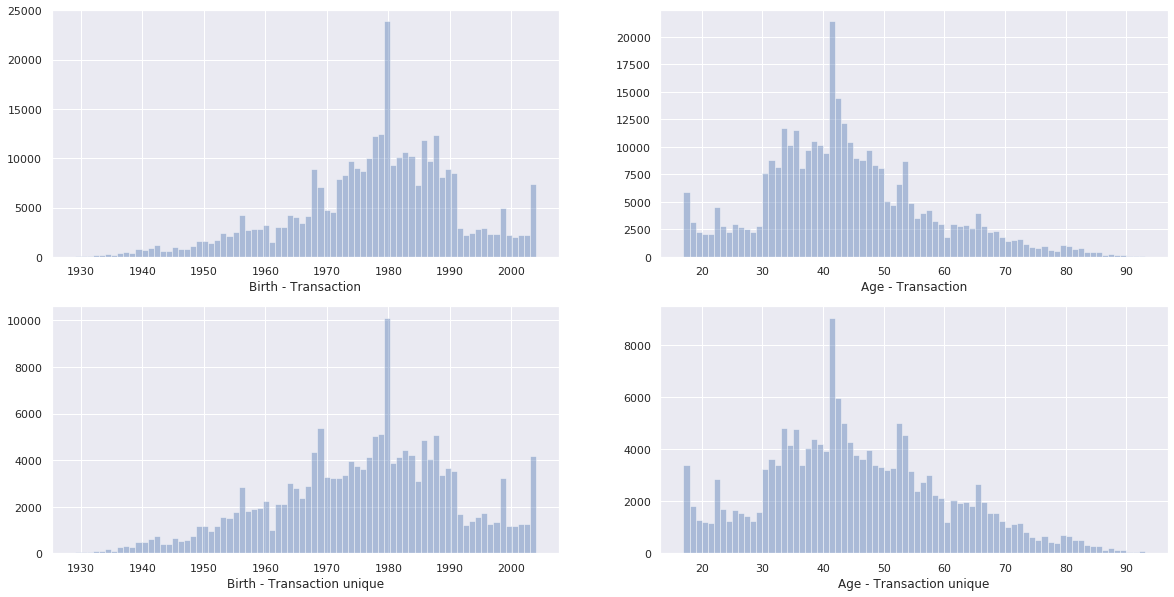

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions['birth'], axlabel='Birth - Transaction', kde=False, bins=76, ax=axes[0, 0])
sns.distplot(df_transactions['age'], axlabel='Age - Transaction', kde=False, bins=76, ax=axes[0, 1])
sns.distplot(df_transactions.drop_duplicates('session_id')['birth'], axlabel='Birth - Transaction unique', kde=False, bins=76, ax=axes[1, 0])
sns.distplot(df_transactions.drop_duplicates('session_id')['age'], axlabel='Age - Transaction unique', kde=False, bins=76, ax=axes[1, 1])

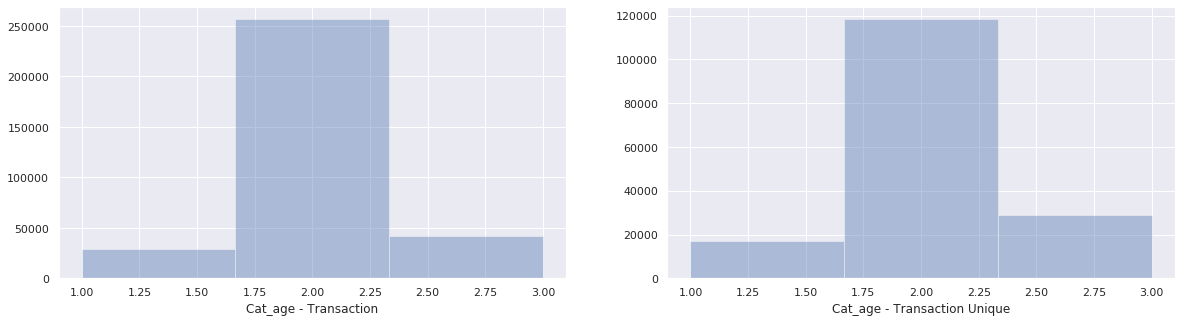

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_transactions['cat_age'], axlabel='Cat_age - Transaction', kde=False, bins=3, ax=axes[0])
sns.distplot(df_transactions.drop_duplicates('session_id')['cat_age'], axlabel='Cat_age - Transaction Unique', kde=False, bins=3, ax=axes[1])

Nous remarquons deux choses, premièrement, il a un nombre très important d'achat pour l'age de 41 ans (1980), qui n'existait pas dans la table *customers*. Deuxièmenent, nous remarquons toujours la présence d'un pic pour les personnes nées en 2004. 

Egalement, que les personnes de plus de 50 ans ne sont pas des clients récurrents

Nous remarquons, que le nombre de sessions uniques n'influence pas notre répartition des âges. Ce qui veut dire que nous avons un ou des très bons clients dans cette tranche d'âge.

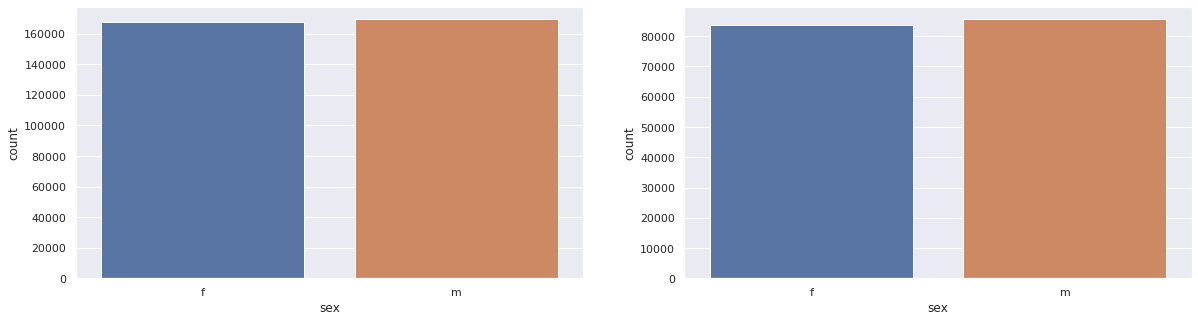

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(df_transactions['sex'], ax=axes[0])
sns.countplot(df_transactions.drop_duplicates('session_id')['sex'], ax=axes[1])

Nous voyons qu'il y a autant d'homme que de femme qui achete sur le site.

In [47]:
df_transactions_achat = df_transactions[['client_id', 'birth', 'sex']].merge(df_transactions.groupby(['client_id', 'age'])['age'].count().reset_index(name = 'nombre achat'), how='left', on='client_id')
df_transactions_achat.drop_duplicates(['client_id', 'age']).nlargest(10, 'nombre achat')

,client_id,birth,sex,age,nombre achat
8,c_1609,1980,m,41,10770
68,c_6714,1968,f,53,3743
78,c_3454,1969,m,52,2639
9,c_1609,1980,m,42,2085
1137,c_4958,1999,m,22,2059
69,c_6714,1968,f,54,728
79,c_3454,1969,m,53,634
1138,c_4958,1999,m,23,503
852,c_3725,1980,f,41,179
2546,c_2140,1977,f,44,173


In [48]:
df = df_transactions[['client_id', 'birth', 'sex']].merge(df_transactions.groupby(['client_id'])['birth'].count().reset_index(name = 'nombre achat'), how='left', on='client_id').drop_duplicates(['client_id'])
df['pourcentage'] = df['nombre achat'] / df_transactions['birth'].count() * 100
df.nlargest(4, 'pourcentage').pourcentage.sum()

6.878558297422433

In [49]:
f"Le Top 4 Client représente {((df_transactions[['client_id', 'birth', 'sex']].merge(df_transactions.groupby(['client_id'])['birth'].count().reset_index(name = 'nombre achat'), how='left', on='client_id').drop_duplicates(['client_id']))['nombre achat'] / df_transactions['birth'].count() * 100).sort_values(ascending=False)[:4].sum():0.2f} % des transactions"

'Le Top 4 Client représente 6.88 % des transactions'

In [50]:
df_transactions_montant = df_transactions[['client_id', 'birth', 'sex']].merge(df_transactions.groupby(['client_id'])['price'].sum().reset_index(name = 'montant achat'), how='left', on='client_id')
df_transactions_montant.drop_duplicates(['client_id']).nlargest(10, 'montant achat')

,client_id,birth,sex,montant achat
4,c_1609,1980,m,162007.34
579,c_4958,1999,m,144257.21
34,c_6714,1968,f,73197.34
39,c_3454,1969,m,54442.92
166,c_7959,1974,f,2564.25
1214,c_4491,1984,f,2540.53
1178,c_8026,1978,m,2537.67
1297,c_2140,1977,f,2527.01
1042,c_8392,1978,f,2515.98
2471,c_7421,1978,m,2511.98


In [51]:
f"Le Top 4 Client représente {((df_transactions_montant.drop_duplicates(['client_id']))['montant achat'] / df_transactions['price'].sum() * 100).sort_values(ascending=False)[:4].sum():0.2f} % du montant des transactions"

'Le Top 4 Client représente 7.49 % du montant des transactions'

Nous voyons qu'il existe de très bons clients, et cela explique les grandes valeurs obtenus 41 et 42 ans avec le client c_1609, 52 et 53 ans avec les clients c_6714 et c_3454 et 22 ans avec le client c_4958.

De plus, ces 4 clients, ont les plus hauts montants de livres achetés. En faisant les tests de corrélation, il serait utile d'écarter ces clients. 


Ainsi, nous allons également, vérifier l'impact de 4 clients sur les données.

#### DataFrame sans le top 4 clients

Nous créons un nouveau dataFrame sans le top 4 clients

In [52]:
top4Client = ["c_1609", "c_6714", "c_3454", "c_4958"]
df_transactions_wo_top4client = df_transactions[~df_transactions["client_id"].isin(top4Client)]
df_transactions_w_top4client = df_transactions[df_transactions["client_id"].isin(top4Client)]

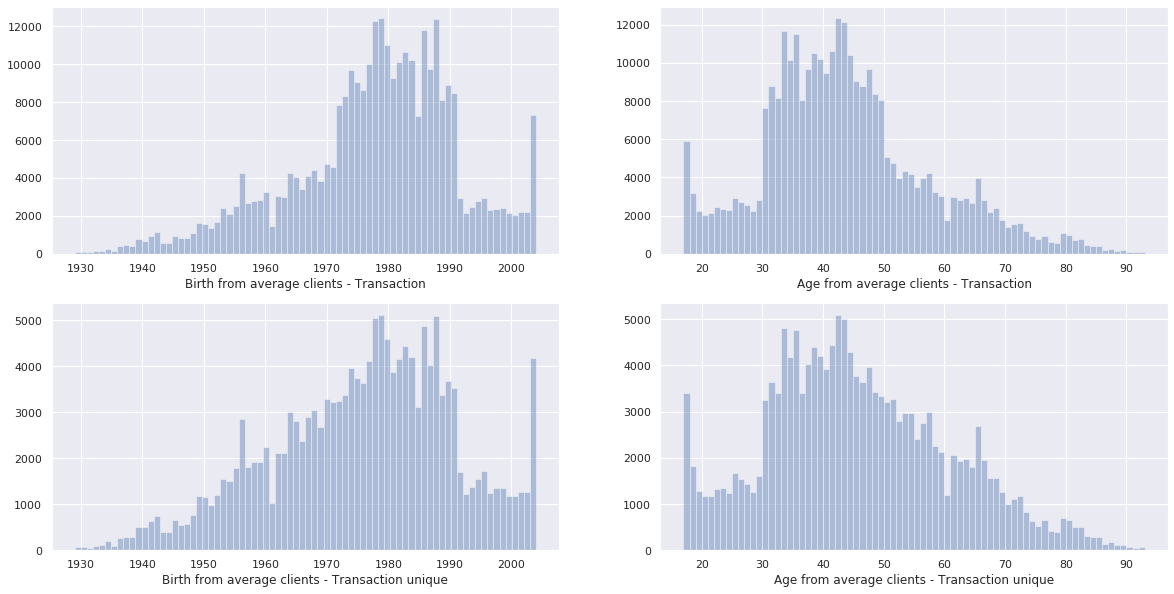

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions_wo_top4client['birth'], axlabel='Birth from average clients - Transaction', kde=False, bins=76, ax=axes[0, 0])
sns.distplot(df_transactions_wo_top4client['age'], axlabel='Age from average clients - Transaction', kde=False, bins=76, ax=axes[0, 1])
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['birth'], axlabel='Birth from average clients - Transaction unique', kde=False, bins=76, ax=axes[1, 0])
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['age'], axlabel='Age from average clients - Transaction unique', kde=False, bins=76, ax=axes[1, 1])

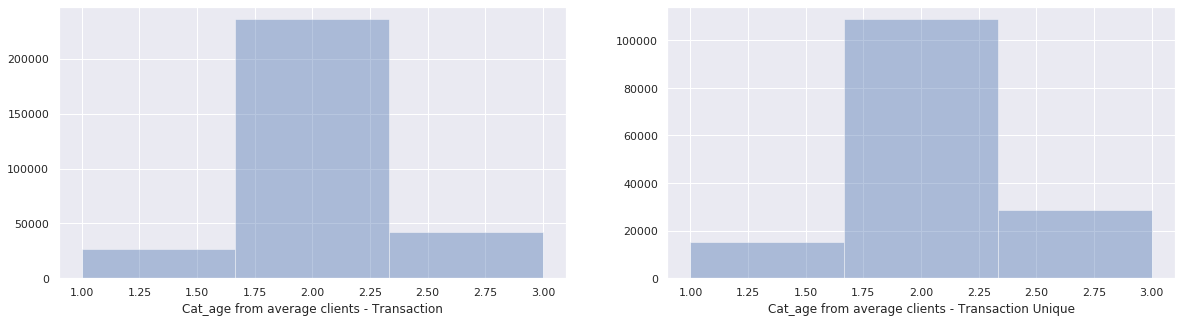

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_transactions_wo_top4client['cat_age'], axlabel='Cat_age from average clients - Transaction', kde=False, bins=3, ax=axes[0])
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['cat_age'], axlabel='Cat_age from average clients - Transaction Unique', kde=False, bins=3, ax=axes[1])

Nous voyons ici, que la catégorie d'age des 30/49 ans est la plus représentative.

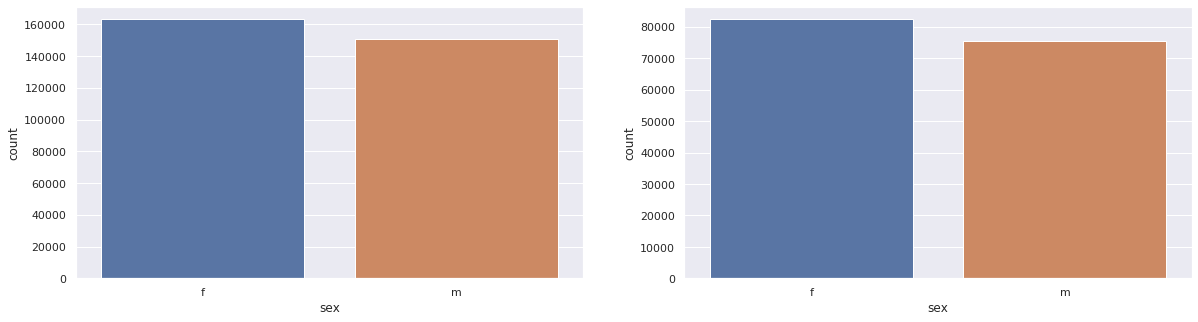

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(df_transactions_wo_top4client['sex'], ax=axes[0])
sns.countplot(df_transactions_wo_top4client.drop_duplicates('session_id')['sex'], ax=axes[1])

L'écart est plus sensible sans le Top 4 Client

### B. Colonne *price*, *cat_price* et *categ*

#### DataFrame avec tous les clients

Nous allons étudier la colonne *price* et *categ*. Nous allons déterminer si il existe une corrélation entre les deux. Les prix s'échalonne de 0.62 euros à 300 euros. Il exite 3 catégories dans *categ*

D'abord, nous allons regarder la colonne *price*, et la comparer avec la même colonne du fichier *products*

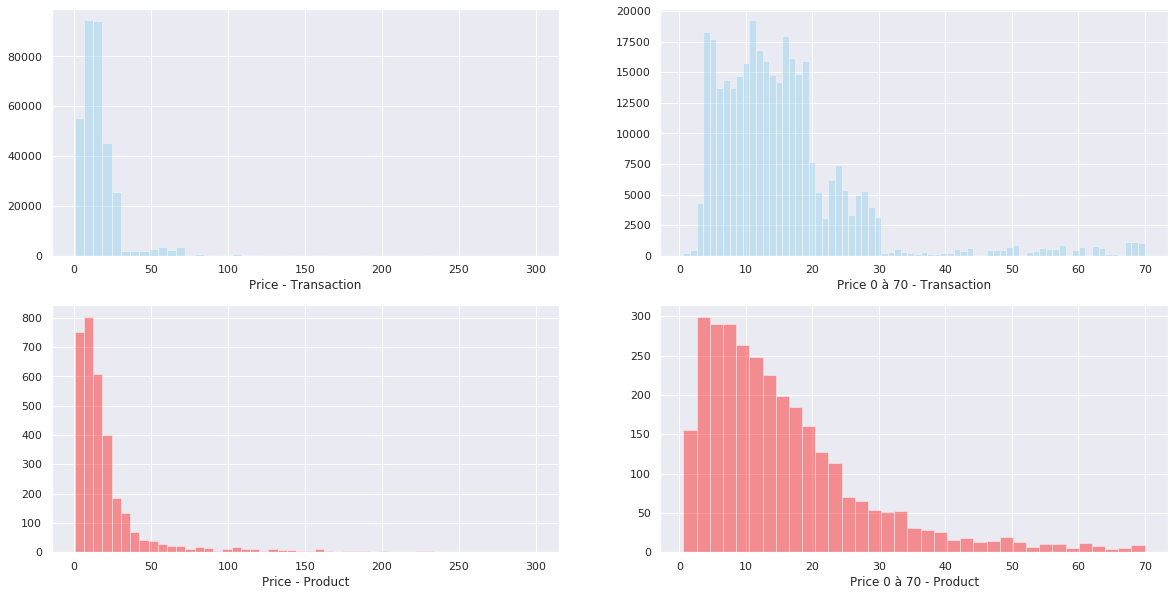

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions['price'], axlabel='Price - Transaction', color="skyblue", kde=False, bins=50, ax=axes[0, 0])
sns.distplot(df_transactions[df_transactions['price'] < 70]['price'], axlabel='Price 0 à 70 - Transaction', color="skyblue", kde=False, bins=70, ax=axes[0, 1])
sns.distplot(products['price'], axlabel='Price - Product', color="red", kde=False, ax=axes[1, 0])
sns.distplot(products[products['price'] < 70]['price'], axlabel='Price 0 à 70 - Product', color="red", kde=False, bins=35, ax=axes[1, 1])

Nous remarquons que la répartition des prix entre la référence produit et la commande des produits est différente. Cette différence est plus marqué sur des prix inférieur à 70 euros. Ce sont les livres entre 10 et 12 euros qui sont les plus vendus. Ensuite, la fourchette entre 6 et 18 euros représente la majorité des ventes.

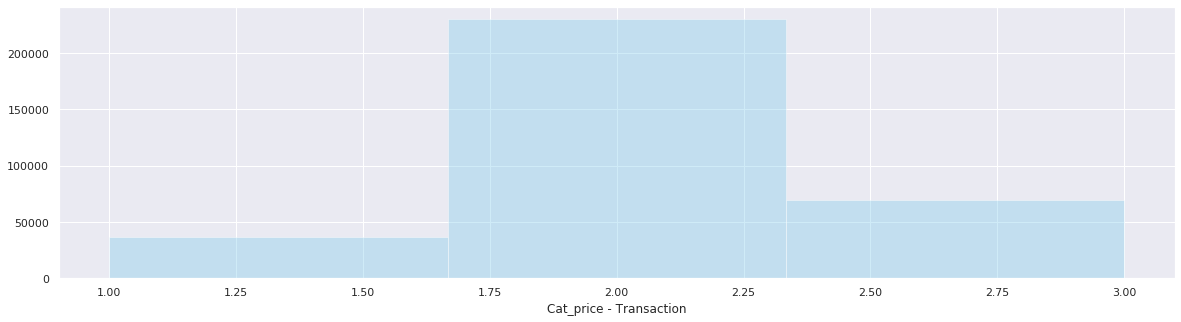

In [92]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(df_transactions['cat_price'], axlabel='Cat_price - Transaction', color="skyblue", kde=False, bins=3)

La colonne *cat_price* nous montre également que la catégorie de livre la plus vendue est celle dont le prix est situé entre 10 et 19.99 euros.

Nous allons regarder la colonne *categ*, et essaye de comprendre ce qu'elle représente

categ
0    AxesSubplot(0.547727,0.125;0.352273x0.755)
1    AxesSubplot(0.547727,0.125;0.352273x0.755)
2    AxesSubplot(0.547727,0.125;0.352273x0.755)
Name: price, dtype: object

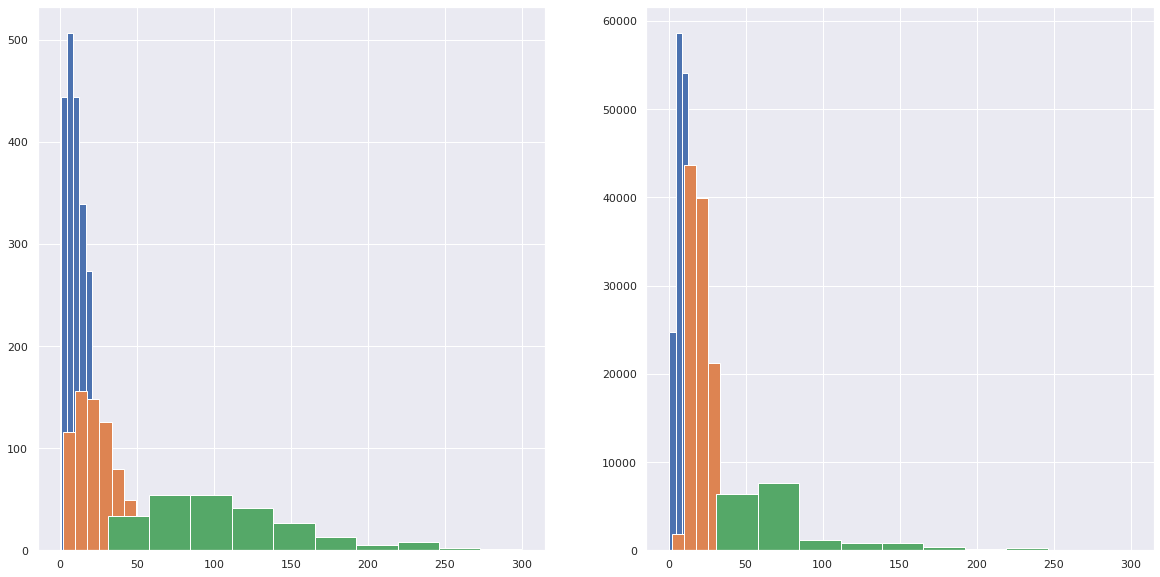

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
products.groupby('categ').price.hist(ax=axes[0])
df_transactions.groupby('categ').price.hist(ax=axes[1])

Nous constatons que *categ* est sensible au prix mais doit représenter des types de livres différents, par exemple, la catégorie 1 représente les livres de poche, la catégorie 2, le livre grand format, et la catégorie 3 les beaux livres comme les encyclopédies. 

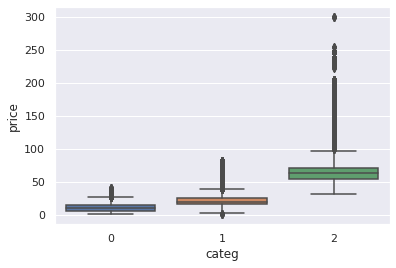

In [59]:
sns.boxplot(x=df_transactions['categ'], y=df_transactions['price'],data=df_transactions)

Nous constatons que les prix de *categ* sont dans un interquartile très petit, avec des bornes peu étendue également. Pour les categ 1 et 2, les outliers sont peu étalés, tandis que sur la categ 3, les outliers sont très étalés avec des prix élevés. Il y a une échalonnage des prix qui est plus marqué pour la categ 3.

#### DataFrame sans le top 4 clients

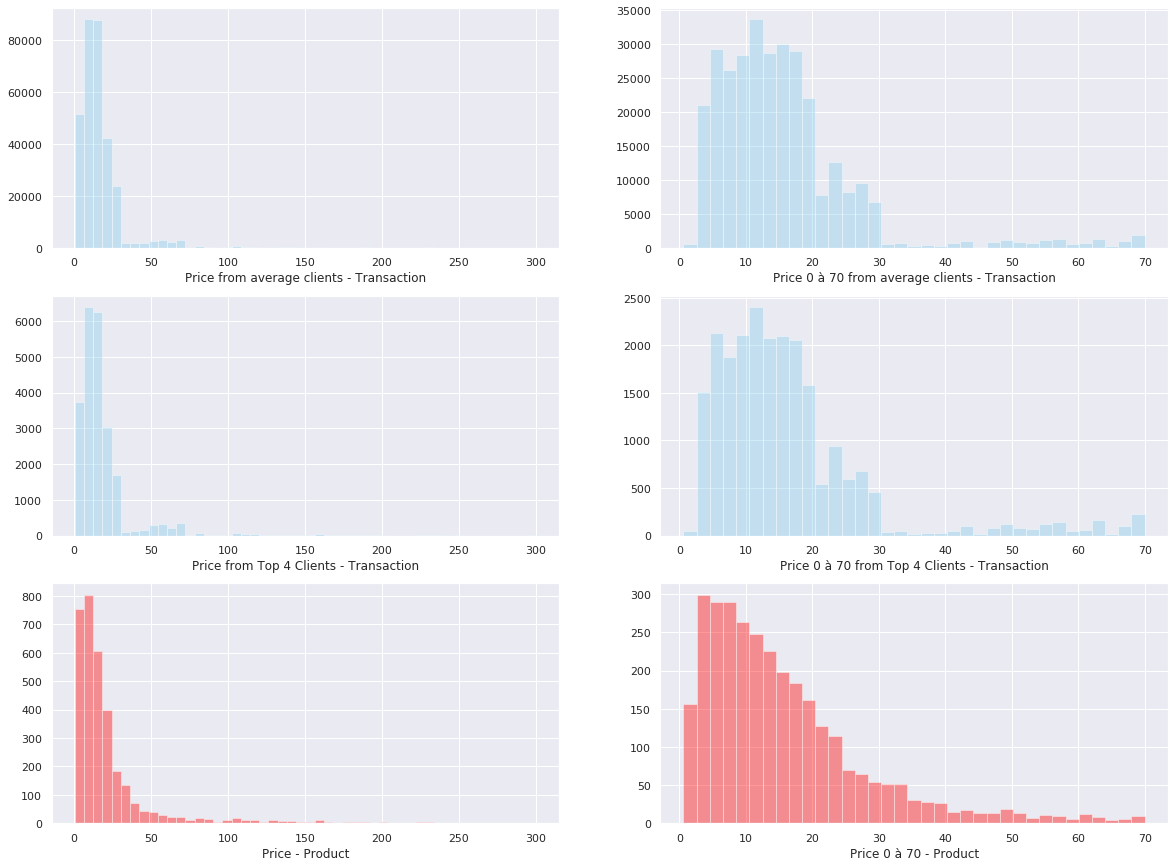

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
sns.distplot(df_transactions_wo_top4client['price'], axlabel='Price from average clients - Transaction', color="skyblue", kde=False, bins=50, ax=axes[0, 0])
sns.distplot(df_transactions_wo_top4client[df_transactions_wo_top4client['price'] < 70]['price'], axlabel='Price 0 à 70 from average clients - Transaction', color="skyblue", kde=False, bins=35, ax=axes[0, 1])
sns.distplot(df_transactions_w_top4client['price'], axlabel='Price from Top 4 Clients - Transaction', color="skyblue", kde=False, bins=50, ax=axes[1, 0])
sns.distplot(df_transactions_w_top4client[df_transactions_w_top4client['price'] < 70]['price'], axlabel='Price 0 à 70 from Top 4 Clients - Transaction', color="skyblue", kde=False, bins=35, ax=axes[1, 1])
sns.distplot(products['price'], axlabel='Price - Product', color="red", kde=False, ax=axes[2, 0])
sns.distplot(products[products['price'] < 70]['price'], axlabel='Price 0 à 70 - Product', color="red", kde=False, bins=35, ax=axes[2, 1])


Nous remarquons que la différence des formes de la courbe des prix des produits achetés par le top 4 des clients ou les clients normaux n'est pas significative.

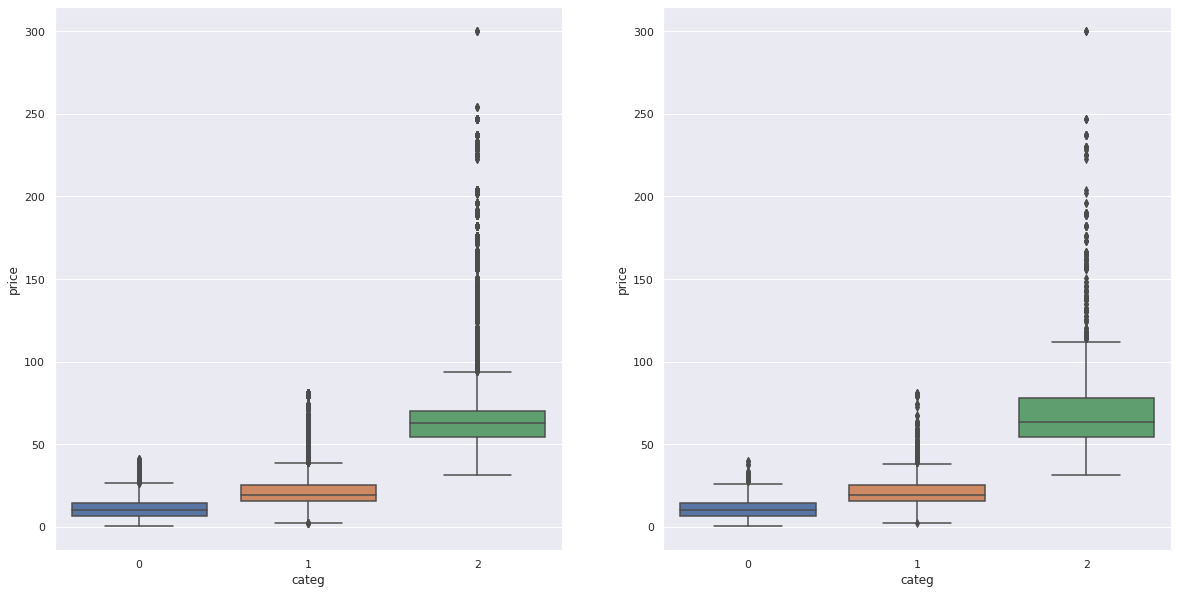

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x=df_transactions_wo_top4client['categ'], y=df_transactions['price'],data=df_transactions, ax=axes[0])
sns.boxplot(x=df_transactions_w_top4client['categ'], y=df_transactions['price'],data=df_transactions, ax=axes[1])

Nous constatons que, pour la categ 2, l'ecart-type est plus grande pour le Top 4.

### C. Colonne *date*, *weekday*, *daytime*, *month*, *week*, *year*

#### DataFrame avec tous les clients

Nous allons vérifier les colonnes liés aux dates

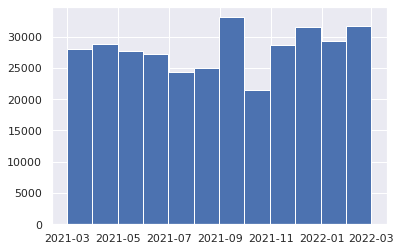

In [62]:
df_transactions['date'].hist(bins = 12)

In [63]:
df_transactions.nlargest(1, 'date').date

276460   2022-02-28 23:59:58.040472
Name: date, dtype: datetime64[ns]

In [64]:
df_transactions.nsmallest(1, 'date').date

240413   2021-03-01 00:01:07.843138
Name: date, dtype: datetime64[ns]

Nous constatons bien que les dates débutent en mars 2021 et finissent fin février 2022, soit sur 12 mois

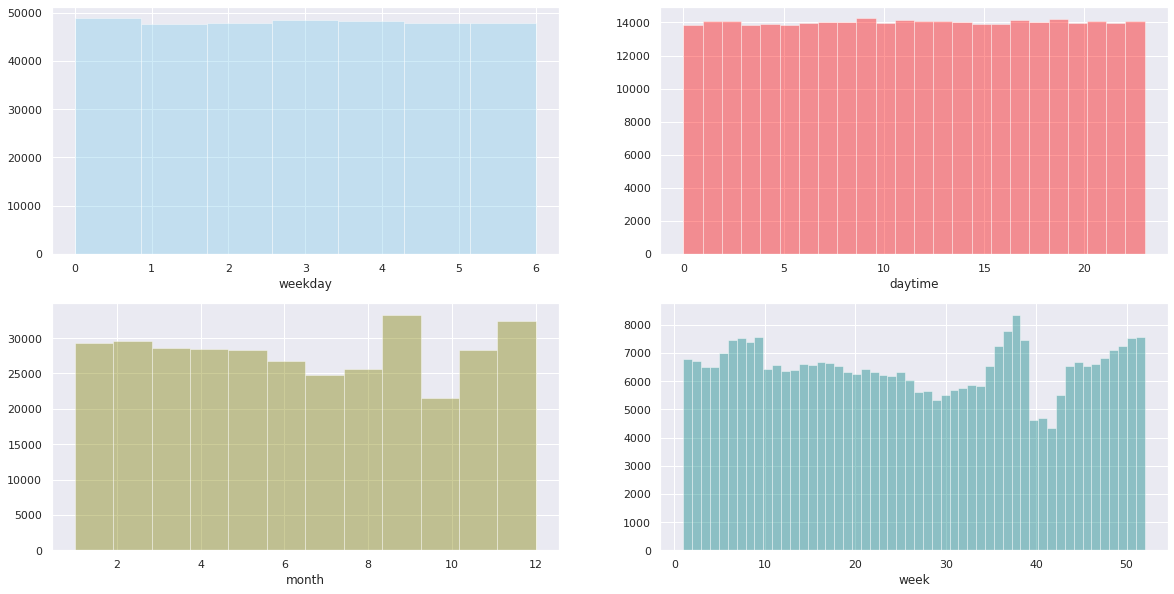

In [65]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions['weekday'], color="skyblue", kde=False, bins=7, ax=axes[0, 0])
sns.distplot(df_transactions['daytime'], color="red", kde=False, bins=24, ax=axes[0, 1])
sns.distplot(df_transactions['month'], color="olive", kde=False, bins=12, ax=axes[1, 0])
sns.distplot(df_transactions['week'], color="teal", kde=False, bins=52, ax=axes[1, 1])

Tout d'abord, il existe de moments dans l'année où le volume de vents est plus important. En septembre, à la rentrée, et en novembre et décembre, pendant les fêtes de fin d'année. Nous remarquons, également, que le jour de la semaine et l'heure d'achat non pas d'influence sur le volume de vente. 


Nous allons investiger sur les pics de vents, mais aussi sur l'influence des jours de la semaine et de l'heure.

Tout d'abord, nous allons prendre un échantillion de 1 %

In [66]:
df_transactions_sample = df_transactions.sample(3367)

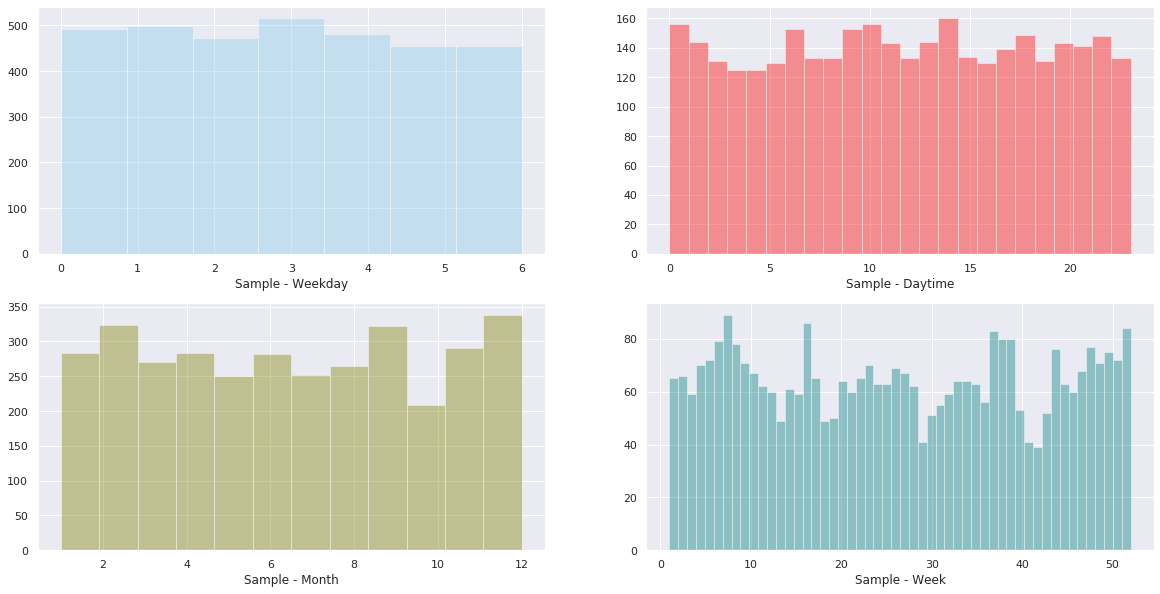

In [67]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions_sample['weekday'], axlabel='Sample - Weekday', color="skyblue", kde=False, bins=7, ax=axes[0, 0])
sns.distplot(df_transactions_sample['daytime'], axlabel='Sample - Daytime', color="red", kde=False, bins=24, ax=axes[0, 1])
sns.distplot(df_transactions_sample['month'], axlabel='Sample - Month', color="olive", kde=False, bins=12, ax=axes[1, 0])
sns.distplot(df_transactions_sample['week'], axlabel='Sample - Week', color="teal", kde=False, bins=52, ax=axes[1, 1])

Nous remarquons qu'avec un échantillon de 1 %, la représentation des graphiques est similaire.

#### DataFrame sans le top 4 clients

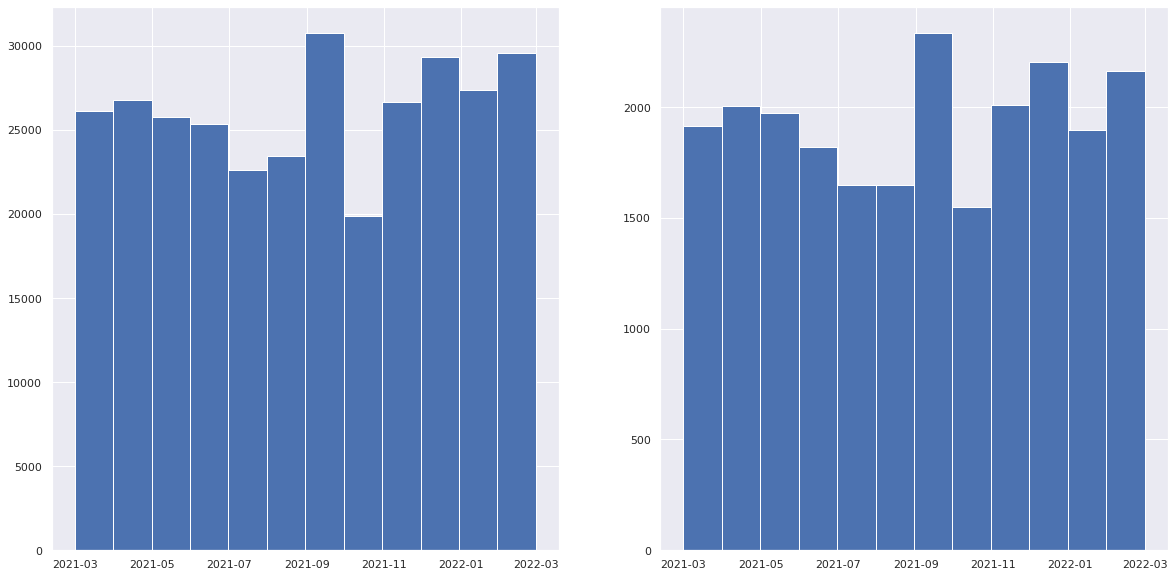

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
df_transactions_wo_top4client['date'].hist(bins = 12, ax=axes[0])
df_transactions_w_top4client['date'].hist(bins = 12, ax=axes[1])

La répartition dans le temps entre les *average* clients et le top 4 est similaire

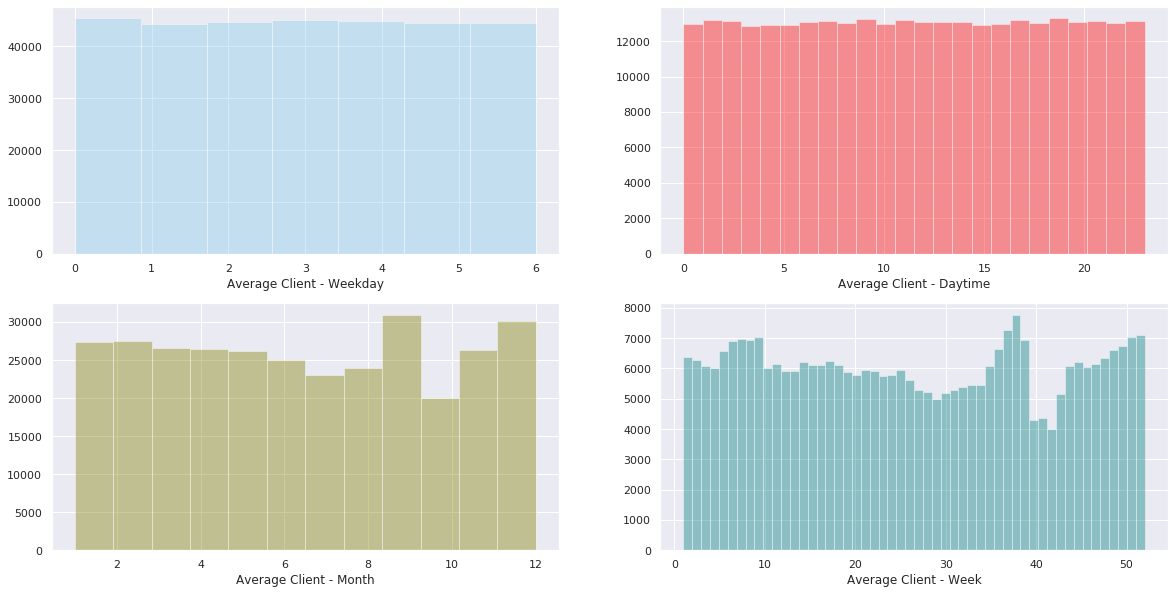

In [69]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions_wo_top4client['weekday'], axlabel='Average Client - Weekday', color="skyblue", kde=False, bins=7, ax=axes[0, 0])
sns.distplot(df_transactions_wo_top4client['daytime'], axlabel='Average Client - Daytime', color="red", kde=False, bins=24, ax=axes[0, 1])
sns.distplot(df_transactions_wo_top4client['month'], axlabel='Average Client - Month', color="olive", kde=False, bins=12, ax=axes[1, 0])
sns.distplot(df_transactions_wo_top4client['week'], axlabel='Average Client - Week', color="teal", kde=False, bins=52, ax=axes[1, 1])

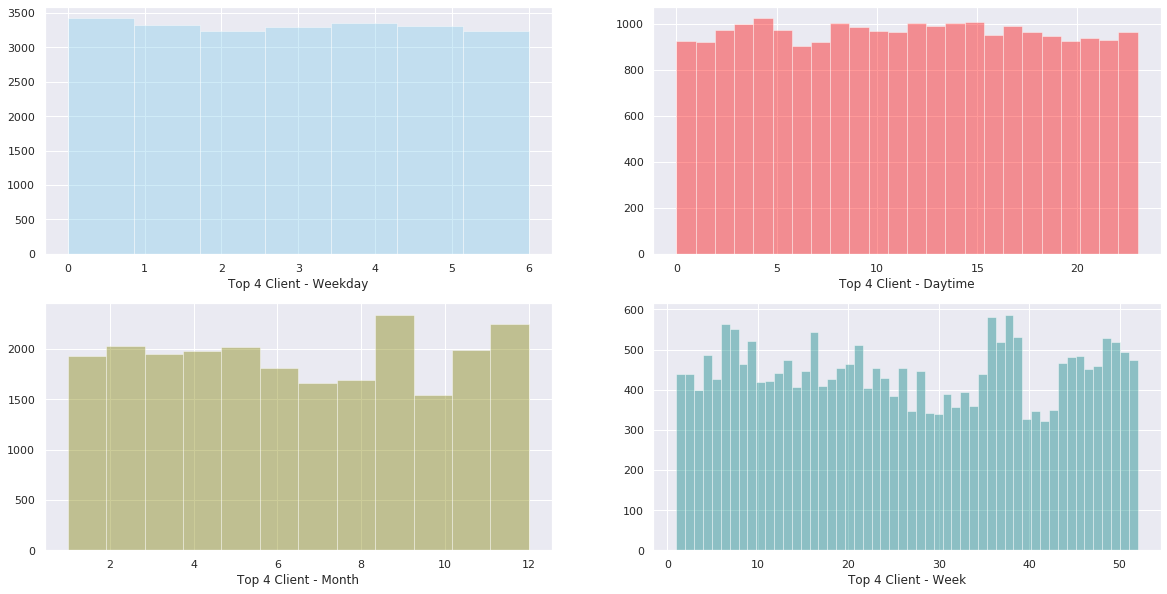

In [70]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions_w_top4client['weekday'], axlabel='Top 4 Client - Weekday', color="skyblue", kde=False, bins=7, ax=axes[0, 0])
sns.distplot(df_transactions_w_top4client['daytime'], axlabel='Top 4 Client - Daytime', color="red", kde=False, bins=24, ax=axes[0, 1])
sns.distplot(df_transactions_w_top4client['month'], axlabel='Top 4 Client - Month', color="olive", kde=False, bins=12, ax=axes[1, 0])
sns.distplot(df_transactions_w_top4client['week'], axlabel='Top 4 Client - Week', color="teal", kde=False, bins=52, ax=axes[1, 1])

Nous constatons que le Top 4 Client n'a pas une influence significative sur la répartition des achats dans la semaine ou dans la journée

### D. Colonne *session_amount*, *session_nb_produit*  et *session_categ*

#### DataFrame avec tous les clients

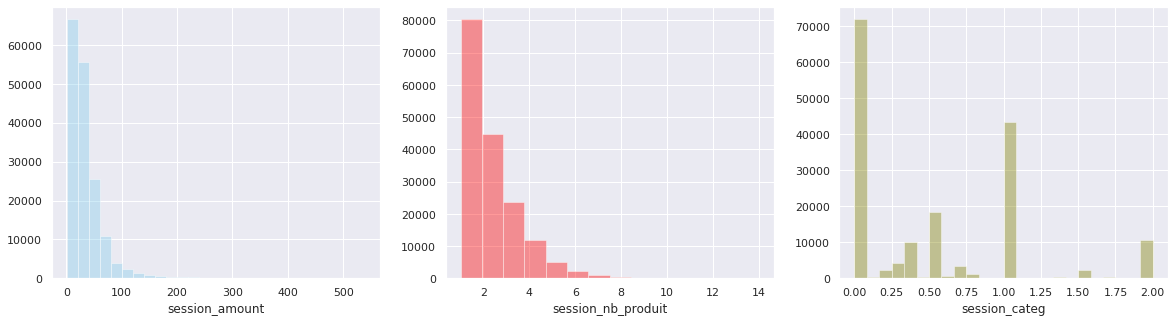

In [71]:
f, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.distplot(df_transactions.drop_duplicates('session_id')['session_amount'], color="skyblue", kde=False, bins=27, ax=axes[0])
sns.distplot(df_transactions.drop_duplicates('session_id')['session_nb_produit'], color="red", kde=False, bins=14, ax=axes[1])
sns.distplot(df_transactions.drop_duplicates('session_id')['session_categ'], color="olive", kde=False, bins=24, ax=axes[2])

Les panier d'un motant entre 0.69 et 40 euros. Ainsi, l'achat unique est, également, le plus représenté. Il semble qu'il n'y ait peu de melange de categ dans un même panier.

#### DataFrame sans le top 4 clients

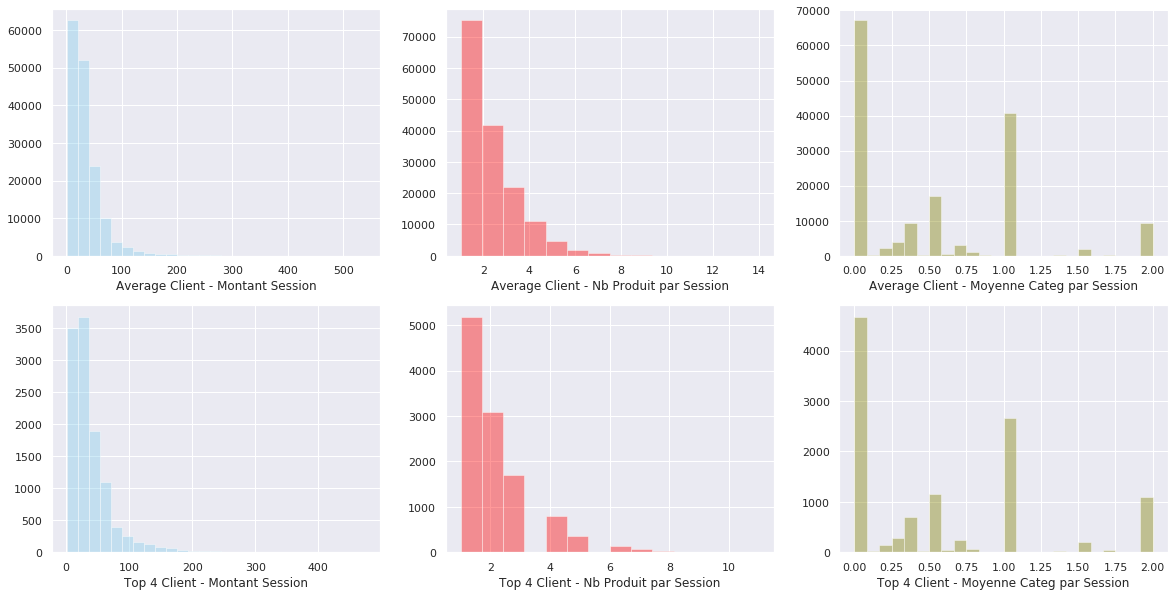

In [72]:
f, axes = plt.subplots(2, 3, figsize=(20, 10))
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['session_amount'], axlabel='Average Client - Montant Session', color="skyblue", kde=False, bins=27, ax=axes[0, 0])
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['session_nb_produit'], axlabel='Average Client - Nb Produit par Session', color="red", kde=False, bins=14, ax=axes[0, 1])
sns.distplot(df_transactions_wo_top4client.drop_duplicates('session_id')['session_categ'], axlabel='Average Client - Moyenne Categ par Session', color="olive", kde=False, bins=24, ax=axes[0, 2])
sns.distplot(df_transactions_w_top4client.drop_duplicates('session_id')['session_amount'], axlabel='Top 4 Client - Montant Session', color="skyblue", kde=False, bins=27, ax=axes[1, 0])
sns.distplot(df_transactions_w_top4client.drop_duplicates('session_id')['session_nb_produit'], axlabel='Top 4 Client - Nb Produit par Session', color="red", kde=False, bins=14, ax=axes[1, 1])
sns.distplot(df_transactions_w_top4client.drop_duplicates('session_id')['session_categ'], axlabel='Top 4 Client - Moyenne Categ par Session', color="olive", kde=False, bins=24, ax=axes[1, 2])

### E. Conclusion

Nous avons 4 gros clients qui représentent plus de 7 % du montant des transactions et plus de 6 % du total des transactions, ils ont malgré tout, peu d'influence sur le profil des ventes. Néanmoins, nous approfondirons cela dans la 5e partie, pour essayer de determiner le profil de ces clients.


Les principaux clients sont dans la tranche 30 - 49 ans. Après cette age, nous avons des clients ponctuels effectuant un achat souvent unique, qui semblent peu familiers avec des achats sur internet. En dessous de 30 ans, nous avons peu de clients, alors qu'ils sont généralement lecteurs, et plus connectés à Internet. Ce point devra être developpé afin de determiner les causes.


Les livres les plus vendus sont dans une fourchette de 10 et 12 euros, la majorité des ventes de livres étant entre 6 et 18 euros. Nous allons analyser ces données pour conaaître les produits les plus vendus, ainsi que la répartition par *categ*


Finalement, nous avons constaté que l'heure et le jour d'achat n'avaient pas d'influence sur le volume des ventes. Par contre, il existe deux périodes, Septembre / Octobre et Novembre / Décembre, où les ventes s'écartent de la moyenne annuelle. Nous allons, également, tâcher de comprendre les raisons de ces écarts.

## 5. Analyses des données

### C. Produits les plus vendus

In [73]:
df_transactions[['id_prod','price']].groupby('id_prod').count().nlargest(10, 'price')

,price
id_prod,
1_369,1081
1_417,1062
1_498,1036
1_414,1027
1_425,1013
1_398,952
1_406,946
1_413,944
1_403,939


In [74]:
bestProduct = df_transactions.groupby('id_prod').count().nlargest(10, 'price').index
df_transactions_best_product = df_transactions[df_transactions['id_prod'].isin(bestProduct)]
df_transactions_best_product[['id_prod', 'price', 'categ']].drop_duplicates('id_prod')

,id_prod,price,categ
2073,1_407,15.99,1
6509,1_369,23.99,1
36122,1_403,17.99,1
49351,1_413,17.99,1
62012,1_414,23.83,1
70003,1_417,20.99,1
74517,1_398,10.17,1
103857,1_498,23.37,1
113812,1_406,24.81,1
143520,1_425,16.99,1


Les 10 produits les plus vendus font tous partie de la *categ* 1, avec un prix variant de 10.17 à 24.81. Le premier livre d'une autre *categ* est en 43ème position.

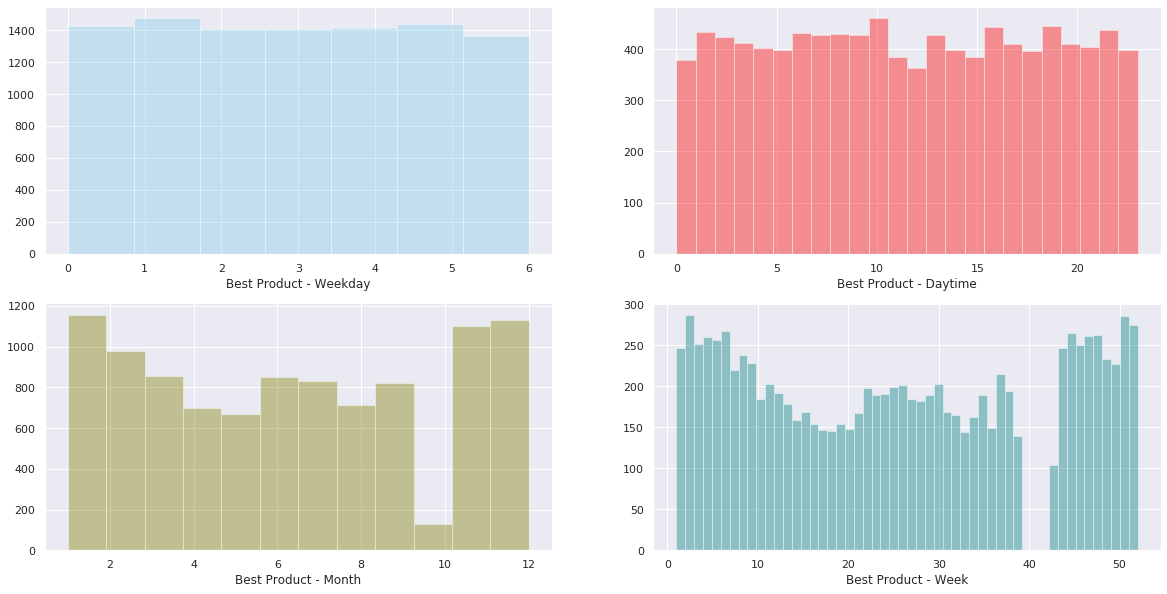

In [75]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df_transactions_best_product['weekday'], axlabel='Best Product - Weekday', color="skyblue", kde=False, bins=7, ax=axes[0, 0])
sns.distplot(df_transactions_best_product['daytime'], axlabel='Best Product - Daytime', color="red", kde=False, bins=24, ax=axes[0, 1])
sns.distplot(df_transactions_best_product['month'], axlabel='Best Product - Month', color="olive", kde=False, bins=12, ax=axes[1, 0])
sns.distplot(df_transactions_best_product['week'], axlabel='Best Product - Week', color="teal", kde=False, bins=52, ax=axes[1, 1])

Nous remarquons, dans le dernier graphique, qu'il n'y a pas eu de ventes pendant 3 semaines en Octobre. Est-ce simplement les meilleurs produits, ou cela s'étends sur d'autres produits ?

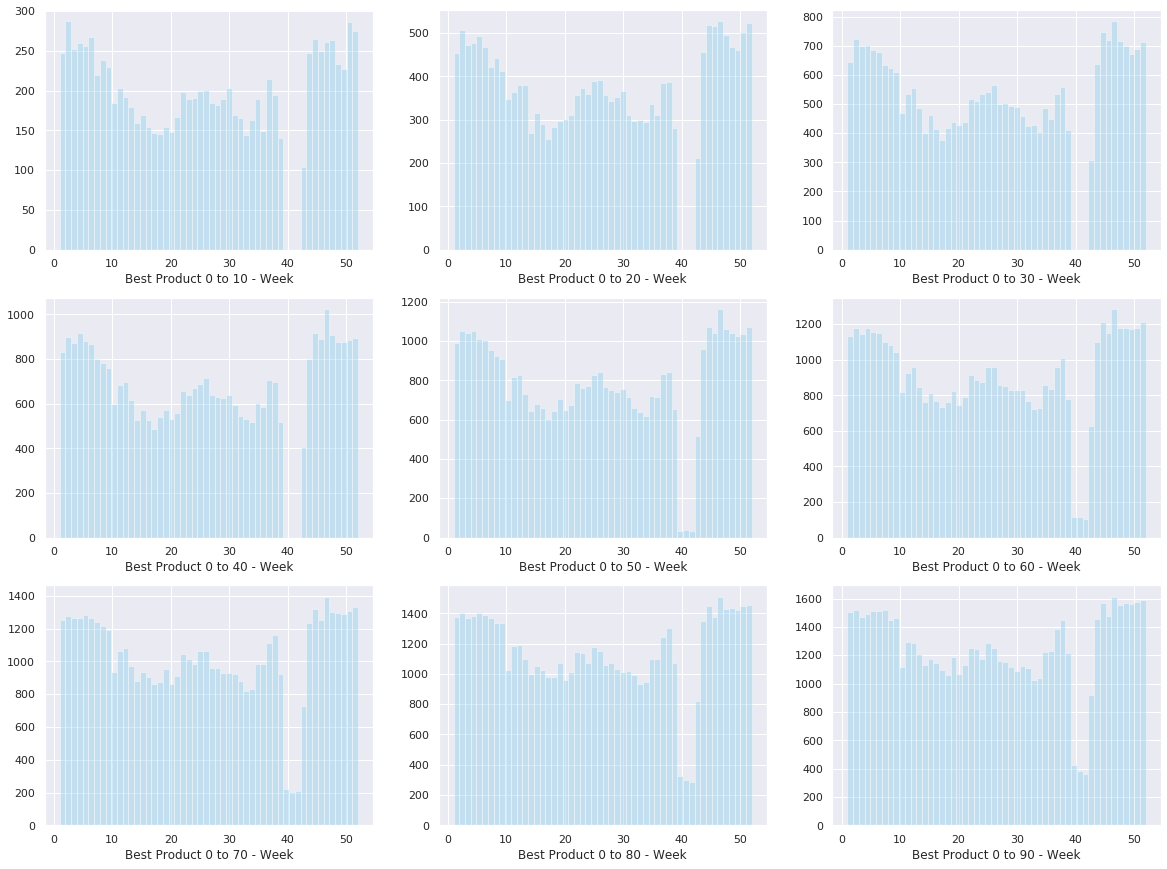

In [76]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
for i in range(9):
    j = i + 1
    df = df_transactions[df_transactions['id_prod'].isin(df_transactions.groupby('id_prod').count().nlargest(j * 10, 'price').index)]
    sns.distplot(df['week'], axlabel=f'Best Product 0 to {j * 10} - Week', color="skyblue", kde=False, bins=52, ax=axes[i//3, i%3])

Nous voyons que progrssivement, à partir du 40e produit, nous avons de nouveau des ventes en prendant ces trois semaines en Octobre. Nous allons lister ces produits.

In [77]:
df_transactions[df_transactions['week'].between(40, 42)].drop_duplicates('id_prod').describe()

,birth,price,categ,age,weekday,daytime,month,week,year,session_amount,session_nb_produit,session_categ
count,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.000000,1736.0,1736.000000,1736.0,1736.000000,1736.000000,1736.000000
mean,1979.790899,17.429487,0.156682,41.209101,3.166475,11.421083,10.0,40.985023,2021.0,35.871722,2.542627,0.149539
std,10.291573,26.712932,0.537570,10.291573,1.988568,7.030243,0.0,0.804028,0.0,36.216976,1.340318,0.514775
min,1931.000000,0.620000,0.000000,17.000000,0.000000,0.000000,10.0,40.000000,2021.0,0.620000,1.000000,0.000000
25%,1975.000000,6.250000,0.000000,35.000000,1.000000,5.000000,10.0,40.000000,2021.0,16.310000,1.000000,0.000000
50%,1980.000000,10.990000,0.000000,41.000000,3.000000,11.000000,10.0,41.000000,2021.0,27.990000,2.000000,0.000000
75%,1986.000000,16.052500,0.000000,46.000000,5.000000,18.000000,10.0,42.000000,2021.0,42.725000,3.000000,0.000000
max,2004.000000,247.220000,2.000000,90.000000,6.000000,23.000000,10.0,42.000000,2021.0,382.980000,8.000000,2.000000


Nous allons calculer le pourcentage de produits vendu par rapport à la moyenne habituelle.

In [78]:
sell_product = []
for i in range (1, 52):
    sell_product.append(df_transactions[df_transactions['week'].between(i, i+2)].drop_duplicates('id_prod').shape[0] / products.count()['id_prod'] * 100)
    
moy_product = np.mean(sell_product)

In [79]:
f"Nous avons vendu seulement {(df_transactions[df_transactions['week'].between(40, 42)].drop_duplicates('id_prod').shape[0]) / products.count()['id_prod'] * 100:0.2f} % de l'ensemble des produits présents sur le site au lieu de {moy_product:0.2f} %"

"Nous avons vendu seulement 52.83 % de l'ensemble des produits présents sur le site au lieu de 67.82 %"

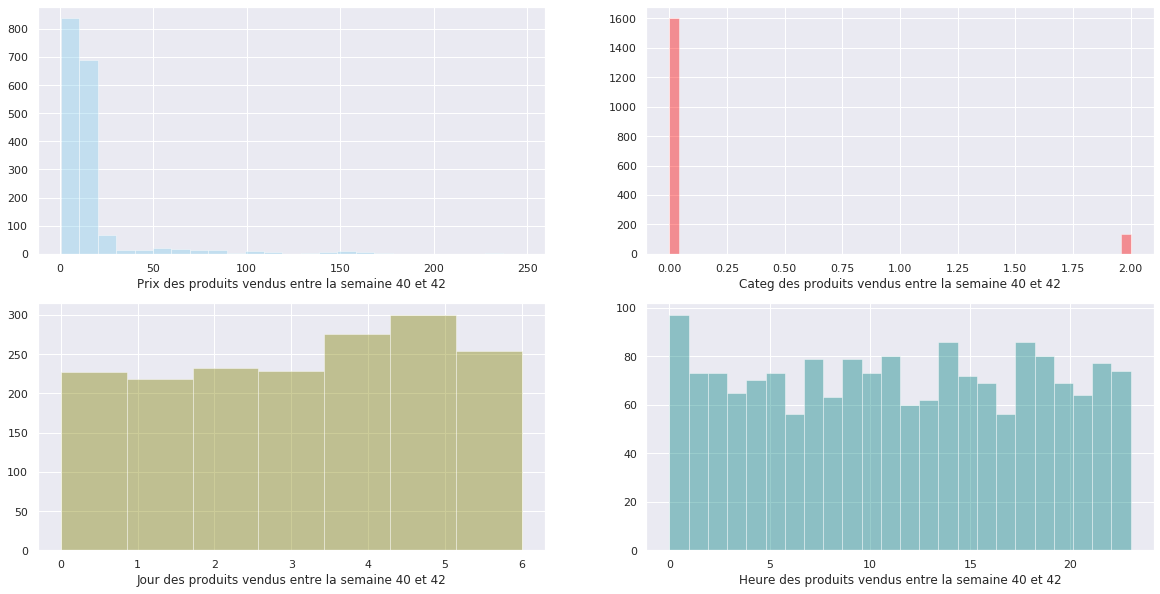

In [80]:
df = df_transactions[df_transactions['week'].between(40, 42)].drop_duplicates('id_prod')

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(df['price'], axlabel='Prix des produits vendus entre la semaine 40 et 42', color="skyblue", kde=False, bins=25, ax=axes[0, 0])
sns.distplot(df['categ'], axlabel='Categ des produits vendus entre la semaine 40 et 42', color="red", kde=False, bins=50, ax=axes[0, 1])
sns.distplot(df['weekday'], axlabel='Jour des produits vendus entre la semaine 40 et 42', color="olive", kde=False, bins=7, ax=axes[1, 0])
sns.distplot(df['daytime'], axlabel='Heure des produits vendus entre la semaine 40 et 42', color="teal", kde=False, bins=24, ax=axes[1, 1])

Nous remarquons qu'aucun livre de *categ* 1 n'a été vendu durant cette période. Est-ce une erreur ? Nous allons comparer le pourcentage de vente de *categ* 1 sur l'année et le comparer à la différence sur cette période.

In [81]:
sell_product = []
sell_product_categ_0 = []
sell_product_categ_1 = []
sell_product_categ_2 = []

for i in range (1, 53):
    sell_product.append(df_transactions[(df_transactions['week'] == i)].drop_duplicates('id_prod').shape[0] / products.count()['id_prod'] * 100)
    sell_product_categ_0.append(df_transactions[(df_transactions['week'] == i) & (df_transactions['categ'] == 0)].shape[0] / df_transactions[df_transactions['week'] == i].count()['id_prod'] * 100)
    sell_product_categ_1.append(df_transactions[(df_transactions['week'] == i) & (df_transactions['categ'] == 1)].shape[0] / df_transactions[df_transactions['week'] == i].count()['id_prod'] * 100)
    sell_product_categ_2.append(df_transactions[(df_transactions['week'] == i) & (df_transactions['categ'] == 2)].shape[0] / df_transactions[df_transactions['week'] == i].count()['id_prod'] * 100)
    
moy_product = np.mean(sell_product_categ_1)

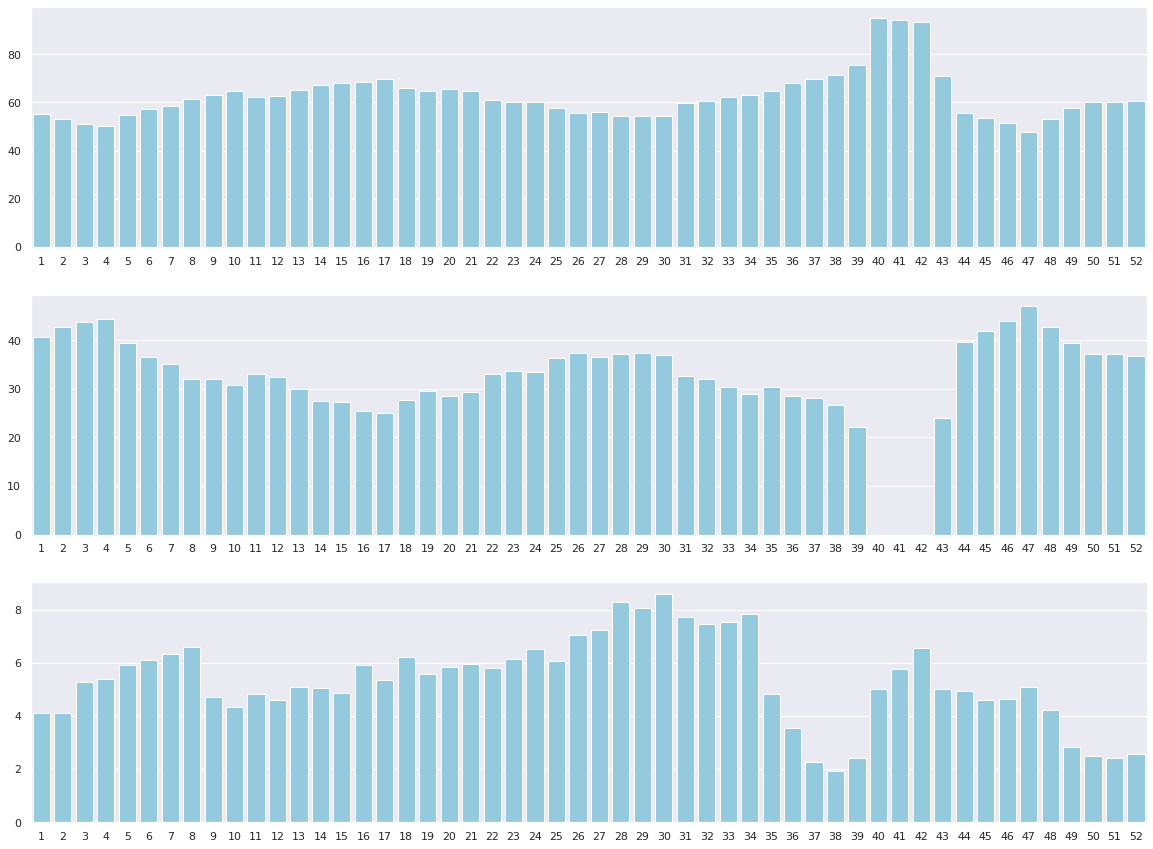

In [82]:
x = pd.Series(range(1,53))

fig, axes = plt.subplots(3, 1, figsize=(20, 15))
sns.barplot(x=x, y=pd.Series(sell_product_categ_0), color="skyblue", ax=axes[0])
sns.barplot(x=x, y=pd.Series(sell_product_categ_1), color="skyblue", ax=axes[1])
sns.barplot(x=x, y=pd.Series(sell_product_categ_2), color="skyblue", ax=axes[2])

Nous constatons bien le fait qu'il n'y ai pas eu de vente 

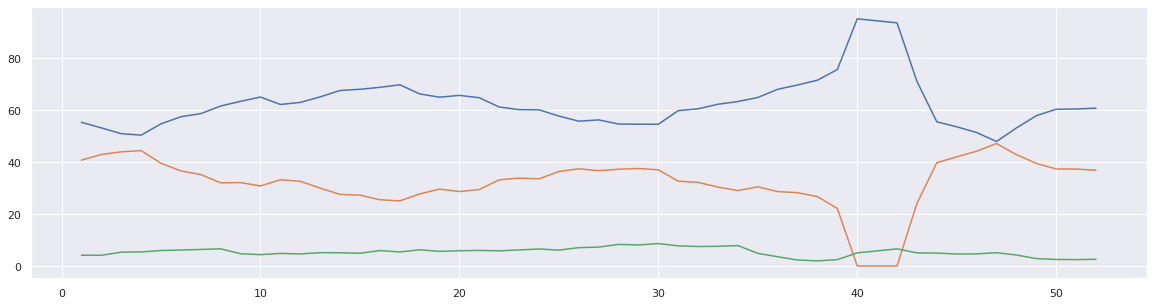

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x=x, y=pd.Series(sell_product_categ_0))
sns.lineplot(x=x, y=pd.Series(sell_product_categ_1))
sns.lineplot(x=x, y=pd.Series(sell_product_categ_2))

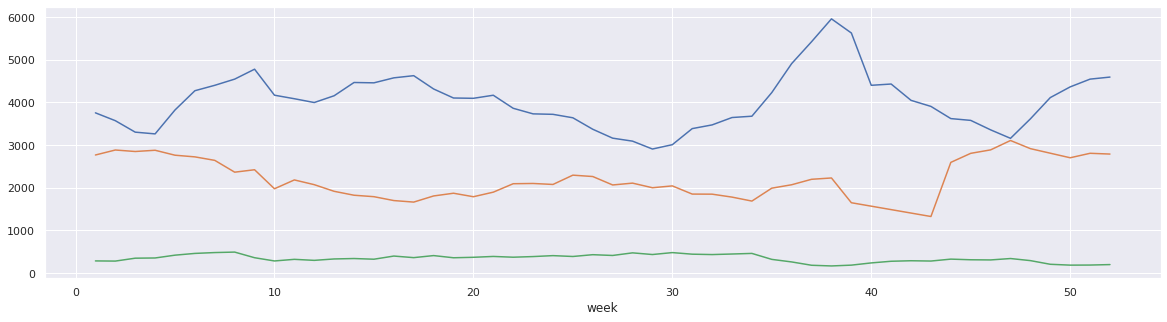

In [84]:
counter = (df_transactions.groupby(['categ', 'week'])['id_prod'].count())
counter_0 = counter.xs(0)
counter_1 = counter.xs(1)
counter_2 = counter.xs(2)

fig, axes = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x=counter_0.index, y=counter_0.values)
sns.lineplot(x=counter_1.index, y=counter_1.values)
sns.lineplot(x=counter_2.index, y=counter_2.values)


In [85]:
counter_0

week
1     3754
2     3570
3     3301
4     3260
5     3821
6     4273
7     4400
8     4545
9     4778
10    4168
11    4085
12    3996
13    4155
14    4466
15    4458
16    4575
17    4626
18    4314
19    4102
20    4095
21    4167
22    3861
23    3730
24    3719
25    3638
26    3369
27    3160
28    3090
29    2905
30    3007
31    3384
32    3471
33    3644
34    3675
35    4230
36    4910
37    5423
38    5959
39    5627
40    4400
41    4430
42    4047
43    3905
44    3619
45    3577
46    3355
47    3156
48    3613
49    4112
50    4363
51    4545
52    4593
Name: id_prod, dtype: int64

In [86]:
df_transactions

,id_prod,date,session_id,client_id,sex,birth,price,categ,age,cat_age,cat_price,weekday,daytime,month,week,year,session_amount,session_nb_produit,session_categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0,44,2,1,5,18,4,14,2021,24.97,3,0.333333
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981,4.99,0,40,2,1,0,11,12,52,2021,4.99,1,0.000000
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985,4.99,0,36,2,1,2,4,10,43,2021,4.99,1,0.000000
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989,4.99,0,32,2,1,6,6,7,26,2021,12.98,2,0.000000
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980,4.99,0,41,2,1,6,8,9,37,2021,59.73,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,0_1920,2021-04-13 18:36:10.252971,s_20115,c_7088,m,1987,25.16,0,34,2,3,1,18,4,15,2021,44.15,2,0.000000
336709,0_1920,2021-05-30 02:37:22.371278,s_41465,c_7748,f,1989,25.16,0,32,2,3,6,2,5,21,2021,25.16,1,0.000000
336710,2_23,2021-09-27 04:47:02.271354,s_96170,c_3976,f,1992,115.99,2,29,1,3,0,4,9,39,2021,115.99,1,2.000000
336711,2_28,2021-05-11 01:31:34.932056,s_32812,c_7613,f,1993,103.50,2,28,1,3,1,1,5,19,2021,179.54,3,1.666667


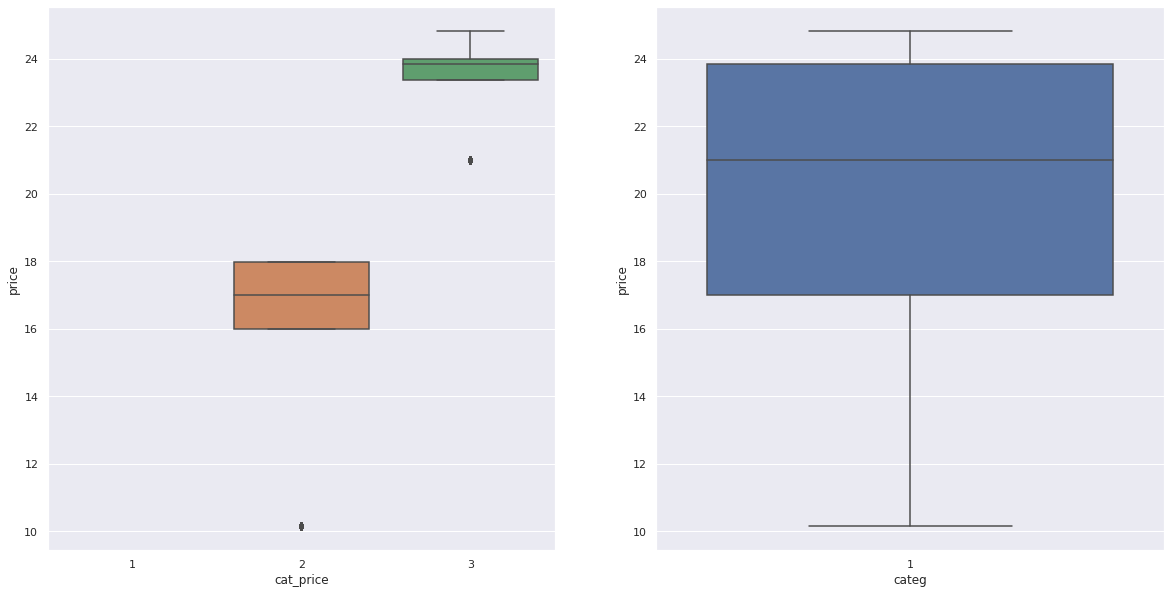

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x=df_transactions_best_product['cat_price'], y=df_transactions_best_product['price'],data=df_transactions_best_product, ax=axes[0])
sns.boxplot(x=df_transactions_best_product['categ'], y=df_transactions_best_product['price'],data=df_transactions_best_product, ax=axes[1])

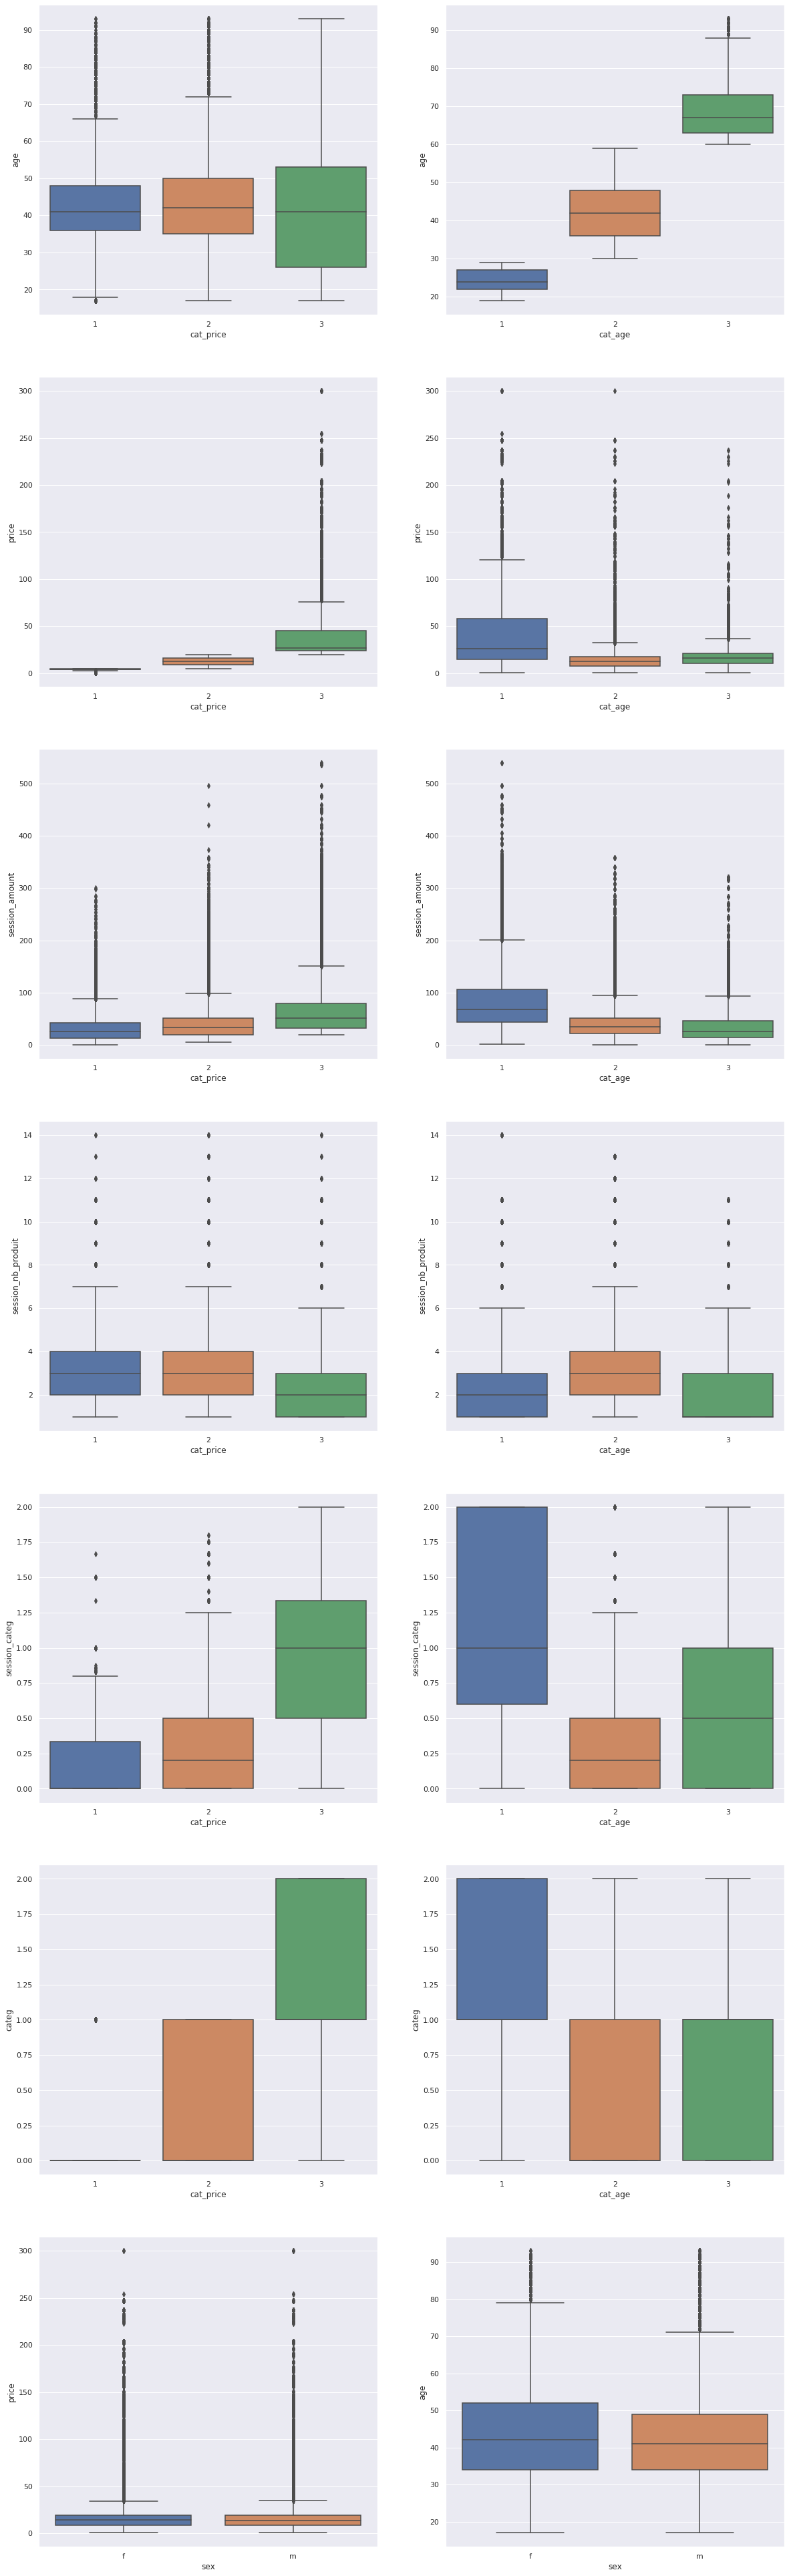

In [118]:
fig, axes = plt.subplots(7, 2, figsize=(20, 70))
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['age'],data=df_transactions, ax=axes[0, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['age'],data=df_transactions, ax=axes[0, 1])
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['price'],data=df_transactions, ax=axes[1, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['price'],data=df_transactions, ax=axes[1, 1])
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['session_amount'],data=df_transactions, ax=axes[2, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['session_amount'],data=df_transactions, ax=axes[2, 1])
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['session_nb_produit'],data=df_transactions, ax=axes[3, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['session_nb_produit'],data=df_transactions, ax=axes[3, 1])
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['session_categ'],data=df_transactions, ax=axes[4, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['session_categ'],data=df_transactions, ax=axes[4, 1])
sns.boxplot(x=df_transactions['cat_price'], y=df_transactions['categ'],data=df_transactions, ax=axes[5, 0])
sns.boxplot(x=df_transactions['cat_age'], y=df_transactions['categ'],data=df_transactions, ax=axes[5, 1])
sns.boxplot(x=df_transactions['sex'], y=df_transactions['price'],data=df_transactions, ax=axes[6, 0])
sns.boxplot(x=df_transactions['sex'], y=df_transactions['age'],data=df_transactions, ax=axes[6, 1])

In [100]:
df_transactions

,id_prod,date,session_id,client_id,sex,birth,price,categ,age,cat_age,cat_price,weekday,daytime,month,week,year,session_amount,session_nb_produit,session_categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0,44,2,1,5,18,4,14,2021,24.97,3,0.333333
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981,4.99,0,40,2,1,0,11,12,52,2021,4.99,1,0.000000
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985,4.99,0,36,2,1,2,4,10,43,2021,4.99,1,0.000000
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989,4.99,0,32,2,1,6,6,7,26,2021,12.98,2,0.000000
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980,4.99,0,41,2,1,6,8,9,37,2021,59.73,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,0_1920,2021-04-13 18:36:10.252971,s_20115,c_7088,m,1987,25.16,0,34,2,3,1,18,4,15,2021,44.15,2,0.000000
336709,0_1920,2021-05-30 02:37:22.371278,s_41465,c_7748,f,1989,25.16,0,32,2,3,6,2,5,21,2021,25.16,1,0.000000
336710,2_23,2021-09-27 04:47:02.271354,s_96170,c_3976,f,1992,115.99,2,29,1,3,0,4,9,39,2021,115.99,1,2.000000
336711,2_28,2021-05-11 01:31:34.932056,s_32812,c_7613,f,1993,103.50,2,28,1,3,1,1,5,19,2021,179.54,3,1.666667


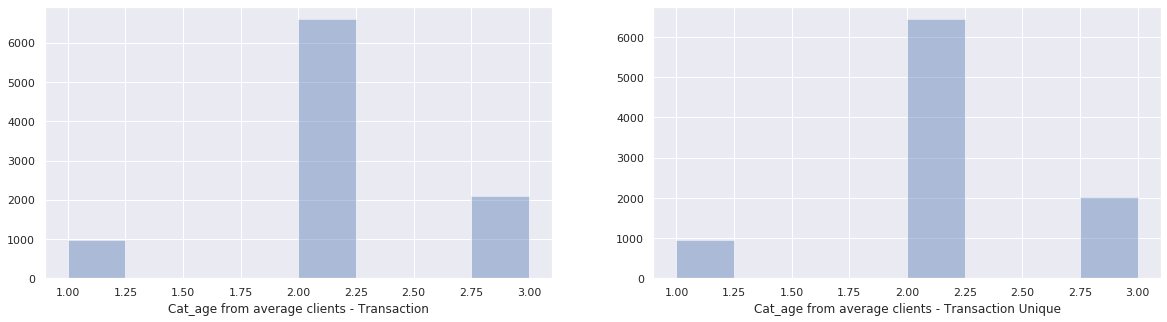

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df_transactions_best_product['cat_age'], axlabel='Cat_age from average clients - Transaction', kde=False, bins=8, ax=axes[0])
sns.distplot(df_transactions_best_product.drop_duplicates('session_id')['cat_age'], axlabel='Cat_age from average clients - Transaction Unique', kde=False, bins=8, ax=axes[1])